# SemEval 2026 Task 5: Rating Plausibility of Word Senses

This notebook replicates the test3.py training pipeline with the following configuration:
- **Model**: RoBERTa-base
- **Pooling**: Weighted attention
- **Dropout**: 0.35
- **Learning Rate**: 8e-6
- **Epochs**: 10
- **Batch Size**: 16

We'll track training and validation losses to analyze overfitting.

## 1. Import Required Libraries

In [13]:
import json
import math
import os
import random
import re
import statistics
import warnings
from pathlib import Path
from typing import Dict, List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.stats import spearmanr
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm
from transformers import AdamW, AutoModel, AutoTokenizer, get_linear_schedule_with_warmup

warnings.filterwarnings("ignore")

# Constants
WSD_PATTERN = re.compile(r"<WSD>(.*?)</WSD>", re.IGNORECASE)
TARGET_TEMPLATE = "[TGT]{token}[/TGT]"
MIN_STD = 0.35
PRED_MIN, PRED_MAX = 1.0, 5.0

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 2. Configuration and Hyperparameters

In [14]:
# Configuration with MORE AGGRESSIVE ANTI-OVERFITTING settings
# Your 0.4 gap is SEVERE - need stronger measures!

config = {
    # Data paths
    'train_path': 'data/train.json',
    'dev_path': 'data/dev.json',
    
    # Model configuration
    'model_name': 'roberta-base',
    'pooling': 'weighted',  # Options: 'cls', 'mean', 'weighted'
    'dropout': 0.60,  # INCREASED from 0.5 → 0.6 (more aggressive)
    
    # Training hyperparameters
    'learning_rate': 3e-6,  # REDUCED from 5e-6 → 3e-6 (slower learning)
    'epochs': 15,
    'batch_size': 16,
    'grad_accumulation': 1,
    'weight_decay': 0.20,  # INCREASED from 0.15 → 0.20 (stronger L2)
    'warmup_ratio': 0.15,
    'max_length': 512,
    
    # Regularization settings
    'label_smoothing': 0.08,  # INCREASED from 0.05 → 0.08 (more noise)
    'gradient_clip': 1.0,
    'huber_delta': 0.5,  # REDUCED from 1.0 → 0.5 (more sensitive to errors)
    
    # Other settings
    'early_stop_patience': 4,  # INCREASED from 3 → 4
    'save_dir': 'outputs',
    'seed': 42,
    'mark_homonym': True,
    'freeze_layers': 0
}

print("=" * 60)
print("🔥 MORE AGGRESSIVE ANTI-OVERFITTING 🔥")
print("=" * 60)
print("\n⚠️  Your 0.4 Spearman gap is SEVERE overfitting!")
print("\nNew aggressive changes:")
print("  ✓ Dropout: 0.50 → 0.60 (60% neurons dropped)")
print("  ✓ Learning Rate: 5e-6 → 3e-6 (40% slower)")
print("  ✓ Weight Decay: 0.15 → 0.20 (33% more L2)")
print("  ✓ Label Smoothing: 0.05 → 0.08 (60% more noise)")
print("  ✓ Huber Delta: 1.0 → 0.5 (2x more sensitive)")
print("\nCurrent configuration:")
for key, value in config.items():
    print(f"  {key}: {value}")

🔥 MORE AGGRESSIVE ANTI-OVERFITTING 🔥

⚠️  Your 0.4 Spearman gap is SEVERE overfitting!

New aggressive changes:
  ✓ Dropout: 0.50 → 0.60 (60% neurons dropped)
  ✓ Learning Rate: 5e-6 → 3e-6 (40% slower)
  ✓ Weight Decay: 0.15 → 0.20 (33% more L2)
  ✓ Label Smoothing: 0.05 → 0.08 (60% more noise)
  ✓ Huber Delta: 1.0 → 0.5 (2x more sensitive)

Current configuration:
  train_path: data/train.json
  dev_path: data/dev.json
  model_name: roberta-base
  pooling: weighted
  dropout: 0.6
  learning_rate: 3e-06
  epochs: 15
  batch_size: 16
  grad_accumulation: 1
  weight_decay: 0.2
  warmup_ratio: 0.15
  max_length: 512
  label_smoothing: 0.08
  gradient_clip: 1.0
  huber_delta: 0.5
  early_stop_patience: 4
  save_dir: outputs
  seed: 42
  mark_homonym: True
  freeze_layers: 0


## 3. Helper Functions and Utilities

In [15]:
def set_seed(seed: int):
    """Set random seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def get_device() -> torch.device:
    """Get the best available device"""
    if torch.cuda.is_available():
        print("Using device: cuda (NVIDIA GPU)")
        return torch.device('cuda')
    elif torch.backends.mps.is_available():
        print("Using device: mps (Apple Silicon GPU)")
        return torch.device('mps')
    else:
        print("Using device: cpu")
        return torch.device('cpu')

def load_json_dataset(filepath: str, source: str) -> pd.DataFrame:
    """Load dataset from JSON file"""
    with open(filepath, 'r') as f:
        data = json.load(f)
    rows = []
    for key, item in data.items():
        row = item.copy()
        row['id'] = key
        row['source'] = row.get('source', source)
        rows.append(row)
    df = pd.DataFrame(rows)
    df['source'] = df['source'].fillna(source)
    return df

def standardize_columns(df: pd.DataFrame) -> pd.DataFrame:
    """Standardize DataFrame columns"""
    text_cols = ['homonym', 'judged_meaning', 'precontext', 'sentence', 'ending',
                 'example_sentence', 'sense_tags', 'sense_synonyms']
    for col in text_cols:
        if col not in df.columns:
            df[col] = ''
        df[col] = df[col].fillna('')
    for numeric in ['average', 'stdev']:
        if numeric not in df.columns:
            df[numeric] = np.nan
        df[numeric] = df[numeric].astype(float)
    if 'choices' not in df.columns:
        df['choices'] = [[] for _ in range(len(df))]
    if 'nonsensical' not in df.columns:
        df['nonsensical'] = [[] for _ in range(len(df))]
    return df

def highlight_target(sentence: str, homonym: str) -> str:
    """Highlight target word in sentence with [TGT] tags"""
    if not sentence or '[TGT]' in sentence or not homonym:
        return sentence
    # FIXED: Use single backslash \b for word boundaries (not double \\b)
    pattern = re.compile(rf"\b{re.escape(homonym)}\b", re.IGNORECASE)
    return pattern.sub(lambda m: TARGET_TEMPLATE.format(token=m.group(0)), sentence, count=1)

def create_text_input(row: pd.Series, mark_homonym: bool) -> str:
    """Create formatted text input for the model"""
    sentence = row['sentence']
    if mark_homonym:
        sentence = highlight_target(sentence, row.get('homonym', ''))
    parts = [
        f"Ambiguous word: {row.get('homonym', '').strip()}.",
        f"Candidate sense: {row.get('judged_meaning', '').strip()}."
    ]
    tags = row.get('sense_tags', '').strip()
    if tags:
        parts.append(f"Sense tags: {tags}.")
    example = row.get('example_sentence', '').strip()
    if example:
        parts.append(f"Dictionary example: {example}")
    precontext = row.get('precontext', '').strip()
    if precontext:
        parts.append(f"Story context: {precontext}")
    parts.append(f"Target sentence: {sentence}")
    ending = row.get('ending', '').strip()
    if ending:
        parts.append(f"Ending: {ending}")
    return " ".join([p for p in parts if p])

def calculate_metrics(predictions, targets, stdevs):
    """Calculate evaluation metrics"""
    spearman_corr, p_val = spearmanr(predictions, targets)
    within_sd = np.mean(np.abs(predictions - targets) <= np.maximum(stdevs, 1.0))
    mse = mean_squared_error(targets, predictions)
    mae = mean_absolute_error(targets, predictions)
    return {
        'spearman_correlation': float(spearman_corr),
        'spearman_pvalue': float(p_val),
        'accuracy_within_sd': float(within_sd),
        'mse': float(mse),
        'mae': float(mae)
    }

def print_metrics(metrics, label):
    """Print metrics in a formatted way"""
    print(f"\n=== {label} Performance ===")
    print(f"Spearman Correlation: {metrics['spearman_correlation']:.4f} (p={metrics['spearman_pvalue']:.4e})")
    print(f"Accuracy Within SD: {metrics['accuracy_within_sd']:.4f} ({metrics['accuracy_within_sd']*100:.2f}%)")
    print(f"Mean Squared Error: {metrics['mse']:.4f}")
    print(f"Mean Absolute Error: {metrics['mae']:.4f}")

print("✓ Helper functions defined")

✓ Helper functions defined


## 4. Dataset and Model Classes

In [16]:
class PlausibilityDataset(Dataset):
    """Dataset class for plausibility rating"""
    def __init__(self, texts: List[str], scores: List[float], weights: List[float], tokenizer, max_length: int):
        self.texts = texts
        self.scores = scores
        self.weights = weights
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'score': torch.tensor(self.scores[idx], dtype=torch.float),
            'weight': torch.tensor(self.weights[idx], dtype=torch.float)
        }


class PlausibilityModel(nn.Module):
    """RoBERTa + LayerNorm + Small regression head with configurable pooling"""
    def __init__(self, model_name: str, dropout: float, pooling: str = 'cls', freeze_layers: int = 0):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        hidden = self.encoder.config.hidden_size
        self.pooling = pooling
        
        # Optional attention scorer for weighted pooling
        if pooling == 'weighted':
            self.attn = nn.Linear(hidden, 1)

        # Regression head: 768 → LayerNorm → 128 → Tanh → Dropout → 1
        self.regressor = nn.Sequential(
            nn.LayerNorm(hidden),
            nn.Linear(hidden, 128),
            nn.Tanh(),
            nn.Dropout(dropout),
            nn.Linear(128, 1)
        )
        self.dropout = nn.Dropout(dropout)
        
        if freeze_layers > 0:
            self._freeze_layers(freeze_layers)

    def _freeze_layers(self, layers_to_freeze: int):
        encoder_layers = getattr(self.encoder, 'encoder', None)
        if encoder_layers is None:
            return
        layer_module = getattr(encoder_layers, 'layer', None)
        if not layer_module:
            return
        for layer in layer_module[:layers_to_freeze]:
            for param in layer.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        # Get encoder outputs
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        hidden_states = outputs.last_hidden_state

        if self.pooling == 'cls':
            pooled = hidden_states[:, 0, :]
        elif self.pooling == 'mean':
            mask = attention_mask.unsqueeze(-1).float()
            denom = mask.sum(dim=1).clamp(min=1e-9)
            pooled = (hidden_states * mask).sum(dim=1) / denom
        elif self.pooling == 'weighted':
            # Attention scorer -> masked softmax -> weighted sum
            scores = self.attn(hidden_states).squeeze(-1)
            scores = scores.masked_fill(attention_mask == 0, -1e9)
            weights = F.softmax(scores, dim=1)
            pooled = (hidden_states * weights.unsqueeze(-1)).sum(dim=1)
        else:
            pooled = hidden_states[:, 0, :]

        pooled = self.dropout(pooled)
        logits = self.regressor(pooled)

        # Clamp only at inference
        if not self.training:
            logits = torch.clamp(logits, min=PRED_MIN, max=PRED_MAX)

        return logits.squeeze(-1)

print("✓ Dataset and Model classes defined")

✓ Dataset and Model classes defined


## 5. Training and Evaluation Functions

In [17]:
def train_one_epoch(model, dataloader, optimizer, scheduler, device, grad_accum, label_smoothing=0.0, gradient_clip=None, huber_delta=1.0):
    """Training loop with Huber loss + variance penalty + label smoothing + gradient clipping
    Also tracks MSE for better visualization
    """
    model.train()
    total_huber_loss = 0.0
    total_mse_loss = 0.0
    
    criterion_huber = nn.HuberLoss(delta=huber_delta)
    criterion_mse = nn.MSELoss()
    
    for step, batch in enumerate(tqdm(dataloader, desc="Training", leave=False)):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        scores = batch['score'].to(device)
        
        # Apply label smoothing: add small noise to targets for regularization
        if model.training and label_smoothing > 0:
            noise = torch.randn_like(scores) * label_smoothing
            scores_smoothed = torch.clamp(scores + noise, min=PRED_MIN, max=PRED_MAX)
        else:
            scores_smoothed = scores
        
        # Forward pass
        preds = model(input_ids, attention_mask)
        
        # Huber loss for training (use smoothed targets)
        loss = criterion_huber(preds, scores_smoothed)
        
        # Add variance penalty: encourage diverse predictions
        pred_std = preds.std()
        target_std = scores.std()
        variance_penalty = torch.relu(target_std - pred_std) * 0.1
        loss = loss + variance_penalty
        
        total_huber_loss += loss.item()
        
        # Track MSE for visualization (use original targets, not smoothed)
        with torch.no_grad():
            mse = criterion_mse(preds, scores)
            total_mse_loss += mse.item()
        
        # Backward pass
        loss = loss / grad_accum
        loss.backward()
        
        if (step + 1) % grad_accum == 0:
            # Gradient clipping to prevent exploding gradients
            if gradient_clip is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)
            
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
    
    # Handle remainder
    if len(dataloader) % grad_accum != 0:
        if gradient_clip is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    avg_huber = total_huber_loss / len(dataloader)
    avg_mse = total_mse_loss / len(dataloader)
    return avg_huber, avg_mse


def evaluate_model(model, dataloader, device, huber_delta=1.0):
    """Evaluate model and return predictions, targets, Huber loss, and MSE loss"""
    model.eval()
    preds, labels = [], []
    total_huber_loss = 0.0
    total_mse_loss = 0.0
    
    criterion_huber = nn.HuberLoss(delta=huber_delta)
    criterion_mse = nn.MSELoss()
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            scores = batch['score'].to(device)
            outputs = model(input_ids, attention_mask)
            
            # Calculate both losses
            huber_loss = criterion_huber(outputs, scores)
            mse_loss = criterion_mse(outputs, scores)
            
            total_huber_loss += huber_loss.item()
            total_mse_loss += mse_loss.item()
            
            preds.append(outputs.cpu().numpy())
            labels.append(scores.cpu().numpy())
    
    avg_huber = total_huber_loss / len(dataloader)
    avg_mse = total_mse_loss / len(dataloader)
    return np.concatenate(preds), np.concatenate(labels), avg_huber, avg_mse

print("✓ Training and evaluation functions defined")
print("  → Now tracking both Huber loss (for training) and MSE loss (for visualization)")

✓ Training and evaluation functions defined
  → Now tracking both Huber loss (for training) and MSE loss (for visualization)


## 6. Load and Prepare Data

In [18]:
# Set seed and get device
set_seed(config['seed'])
device = get_device()
os.makedirs(config['save_dir'], exist_ok=True)

# Load datasets
print("\n" + "=" * 80)
print("SemEval 2026 Task 5: Rating Plausibility of Word Senses")
print("=" * 80)
print("\nLoading datasets...")

train_df = standardize_columns(load_json_dataset(config['train_path'], 'semeval-train'))
dev_df = standardize_columns(load_json_dataset(config['dev_path'], 'semeval-dev'))

print(f"  Training set size: {len(train_df)}")
print(f"  Development set size: {len(dev_df)}")

# Prepare text inputs
for df in [train_df, dev_df]:
    df['sentence'] = df['sentence'].fillna('')
    df['text'] = df.apply(lambda row: create_text_input(row, config['mark_homonym']), axis=1)
    df['weight'] = 1.0  # Uniform weighting

# Display data statistics
print(f"\nTraining Data Statistics:")
print(f"  Mean rating: {train_df['average'].mean():.3f}")
print(f"  Std rating: {train_df['average'].std():.3f}")
print(f"  Min: {train_df['average'].min():.3f}, Max: {train_df['average'].max():.3f}")

print(f"\nDevelopment Data Statistics:")
print(f"  Mean rating: {dev_df['average'].mean():.3f}")
print(f"  Std rating: {dev_df['average'].std():.3f}")
print(f"  Min: {dev_df['average'].min():.3f}, Max: {dev_df['average'].max():.3f}")

Using device: cuda (NVIDIA GPU)

SemEval 2026 Task 5: Rating Plausibility of Word Senses

Loading datasets...
  Training set size: 2280
  Development set size: 588

Training Data Statistics:
  Mean rating: 3.140
  Std rating: 1.187
  Min: 1.000, Max: 5.000

Development Data Statistics:
  Mean rating: 3.118
  Std rating: 1.186
  Min: 1.000, Max: 5.000

Training Data Statistics:
  Mean rating: 3.140
  Std rating: 1.187
  Min: 1.000, Max: 5.000

Development Data Statistics:
  Mean rating: 3.118
  Std rating: 1.186
  Min: 1.000, Max: 5.000


## 7. Initialize Model, Tokenizer, and DataLoaders

In [19]:
print("\n" + "=" * 80)
print("TRANSFORMER MODEL INITIALIZATION")
print("=" * 80)

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained(config['model_name'])

# Create datasets
train_dataset = PlausibilityDataset(
    texts=train_df['text'].tolist(),
    scores=train_df['average'].fillna(3.0).tolist(),
    weights=train_df['weight'].tolist(),
    tokenizer=tokenizer,
    max_length=config['max_length']
)

dev_dataset = PlausibilityDataset(
    texts=dev_df['text'].tolist(),
    scores=dev_df['average'].fillna(3.0).tolist(),
    weights=dev_df['weight'].tolist(),
    tokenizer=tokenizer,
    max_length=config['max_length']
)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=config['batch_size'], shuffle=False)

print(f"✓ Tokenizer: {config['model_name']}")
print(f"✓ Training batches: {len(train_loader)}")
print(f"✓ Development batches: {len(dev_loader)}")


TRANSFORMER MODEL INITIALIZATION
✓ Tokenizer: roberta-base
✓ Training batches: 143
✓ Development batches: 37
✓ Tokenizer: roberta-base
✓ Training batches: 143
✓ Development batches: 37


In [20]:
# Initialize model
model = PlausibilityModel(
    model_name=config['model_name'],
    dropout=config['dropout'],
    pooling=config['pooling'],
    freeze_layers=config['freeze_layers']
).to(device)

# Initialize optimizer
optimizer = AdamW(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])

# Calculate total steps and create scheduler
total_steps = math.ceil(len(train_loader) / config['grad_accumulation']) * config['epochs']
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(total_steps * config['warmup_ratio']),
    num_training_steps=total_steps
)

print(f"\n✓ Model initialized with {config['pooling']} pooling")
print(f"✓ Optimizer: AdamW (lr={config['learning_rate']}, weight_decay={config['weight_decay']})")
print(f"✓ Scheduler: Linear warmup ({config['warmup_ratio']*100:.0f}% warmup)")
print(f"✓ Total training steps: {total_steps}")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



✓ Model initialized with weighted pooling
✓ Optimizer: AdamW (lr=3e-06, weight_decay=0.2)
✓ Scheduler: Linear warmup (15% warmup)
✓ Total training steps: 2145


## 8. Training Loop with Loss Tracking

In [21]:
print("\n" + "=" * 80)
print("TRAINING WITH MORE AGGRESSIVE ANTI-OVERFITTING")
print("=" * 80)

# Track losses and metrics for visualization
train_huber_losses = []
train_mse_losses = []  # NEW: MSE for better visualization
val_huber_losses = []
val_mse_losses = []  # NEW: MSE for better visualization
train_spearman = []
val_spearman = []
best_spearman = -1
patience_counter = 0
best_path = os.path.join(config['save_dir'], 'best_model_test3.pt')

# Training loop
for epoch in range(config['epochs']):
    print(f"\n{'='*80}")
    print(f"Epoch {epoch + 1}/{config['epochs']}")
    print(f"{'='*80}")
    
    # Train with all regularization techniques
    train_huber, train_mse = train_one_epoch(
        model=model,
        dataloader=train_loader,
        optimizer=optimizer,
        scheduler=scheduler,
        device=device,
        grad_accum=config['grad_accumulation'],
        label_smoothing=config.get('label_smoothing', 0.0),
        gradient_clip=config.get('gradient_clip', None),
        huber_delta=config.get('huber_delta', 1.0)
    )
    train_huber_losses.append(train_huber)
    train_mse_losses.append(train_mse)
    print(f"Training - Huber: {train_huber:.4f} | MSE: {train_mse:.4f}")
    
    # Evaluate on training set to track overfitting
    train_preds_epoch, train_actuals_epoch, _, train_mse_eval = evaluate_model(
        model, train_loader, device, huber_delta=config.get('huber_delta', 1.0)
    )
    train_metrics_epoch = calculate_metrics(
        train_preds_epoch,
        train_actuals_epoch,
        train_df['stdev'].fillna(1.0).values
    )
    train_spearman.append(train_metrics_epoch['spearman_correlation'])
    print(f"Training Spearman: {train_metrics_epoch['spearman_correlation']:.4f}")
    
    # Evaluate on validation set
    dev_preds, dev_actuals, val_huber, val_mse = evaluate_model(
        model, dev_loader, device, huber_delta=config.get('huber_delta', 1.0)
    )
    val_huber_losses.append(val_huber)
    val_mse_losses.append(val_mse)
    
    dev_metrics = calculate_metrics(
        dev_preds,
        dev_actuals,
        dev_df['stdev'].fillna(1.0).values
    )
    val_spearman.append(dev_metrics['spearman_correlation'])
    
    print_metrics(dev_metrics, f"Development Set")
    print(f"Validation - Huber: {val_huber:.4f} | MSE: {val_mse:.4f}")
    
    # Calculate and display overfitting gap
    spearman_gap = train_metrics_epoch['spearman_correlation'] - dev_metrics['spearman_correlation']
    print(f"⚠️  Overfitting Gap: {spearman_gap:.4f} (Train - Val Spearman)")
    
    if spearman_gap > 0.3:
        print(f"    🔥 SEVERE OVERFITTING! Consider stopping or increasing regularization")
    elif spearman_gap > 0.15:
        print(f"    ⚠️  High overfitting - monitor closely")
    
    # Save best model
    if dev_metrics['spearman_correlation'] > best_spearman:
        best_spearman = dev_metrics['spearman_correlation']
        patience_counter = 0
        torch.save(model.state_dict(), best_path)
        print(f"✓ Best model saved (Val Spearman: {best_spearman:.4f})")
    else:
        patience_counter += 1
        print(f"No improvement ({patience_counter}/{config['early_stop_patience']})")
        
        if patience_counter >= config['early_stop_patience']:
            print(f"\n⚠️  Early stopping triggered after {epoch + 1} epochs")
            break

print("\n" + "=" * 80)
print("TRAINING COMPLETE")
print("=" * 80)
print(f"Best Validation Spearman: {best_spearman:.4f}")
print(f"Final Overfitting Gap: {train_spearman[-1] - val_spearman[-1]:.4f}")


TRAINING WITH MORE AGGRESSIVE ANTI-OVERFITTING

Epoch 1/15


Training:   0%|          | 0/143 [00:00<?, ?it/s]

Training - Huber: 1.3900 | MSE: 10.1367


Evaluating:   0%|          | 0/143 [00:00<?, ?it/s]

Training Spearman: 0.0148


Evaluating:   0%|          | 0/37 [00:00<?, ?it/s]


=== Development Set Performance ===
Spearman Correlation: -0.0577 (p=1.6231e-01)
Accuracy Within SD: 0.2959 (29.59%)
Mean Squared Error: 5.8922
Mean Absolute Error: 2.1182
Validation - Huber: 0.9395 | MSE: 5.8816
⚠️  Overfitting Gap: 0.0725 (Train - Val Spearman)
✓ Best model saved (Val Spearman: -0.0577)

Epoch 2/15
✓ Best model saved (Val Spearman: -0.0577)

Epoch 2/15


Training:   0%|          | 0/143 [00:00<?, ?it/s]

Training - Huber: 0.6420 | MSE: 3.0507


Evaluating:   0%|          | 0/143 [00:00<?, ?it/s]

Training Spearman: -0.0132


Evaluating:   0%|          | 0/37 [00:00<?, ?it/s]


=== Development Set Performance ===
Spearman Correlation: 0.0216 (p=6.0070e-01)
Accuracy Within SD: 0.5425 (54.25%)
Mean Squared Error: 2.9561
Mean Absolute Error: 1.3911
Validation - Huber: 0.5818 | MSE: 2.9608
⚠️  Overfitting Gap: -0.0348 (Train - Val Spearman)
✓ Best model saved (Val Spearman: 0.0216)

Epoch 3/15
✓ Best model saved (Val Spearman: 0.0216)

Epoch 3/15


Training:   0%|          | 0/143 [00:00<?, ?it/s]

Training - Huber: 0.5017 | MSE: 1.6983


Evaluating:   0%|          | 0/143 [00:00<?, ?it/s]

Training Spearman: 0.1633


Evaluating:   0%|          | 0/37 [00:00<?, ?it/s]


=== Development Set Performance ===
Spearman Correlation: 0.1511 (p=2.3476e-04)
Accuracy Within SD: 0.5340 (53.40%)
Mean Squared Error: 3.0056
Mean Absolute Error: 1.4056
Validation - Huber: 0.5887 | MSE: 3.0093
⚠️  Overfitting Gap: 0.0122 (Train - Val Spearman)
✓ Best model saved (Val Spearman: 0.1511)

Epoch 4/15
✓ Best model saved (Val Spearman: 0.1511)

Epoch 4/15


Training:   0%|          | 0/143 [00:00<?, ?it/s]

Training - Huber: 0.4958 | MSE: 1.6862


Evaluating:   0%|          | 0/143 [00:00<?, ?it/s]

Training Spearman: 0.1913


Evaluating:   0%|          | 0/37 [00:00<?, ?it/s]


=== Development Set Performance ===
Spearman Correlation: 0.1412 (p=5.9446e-04)
Accuracy Within SD: 0.5017 (50.17%)
Mean Squared Error: 3.3283
Mean Absolute Error: 1.4855
Validation - Huber: 0.6284 | MSE: 3.3329
⚠️  Overfitting Gap: 0.0501 (Train - Val Spearman)
No improvement (1/4)

Epoch 5/15


Training:   0%|          | 0/143 [00:00<?, ?it/s]

Training - Huber: 0.4990 | MSE: 1.6785


Evaluating:   0%|          | 0/143 [00:00<?, ?it/s]

Training Spearman: 0.2419


Evaluating:   0%|          | 0/37 [00:00<?, ?it/s]


=== Development Set Performance ===
Spearman Correlation: 0.1670 (p=4.7043e-05)
Accuracy Within SD: 0.5425 (54.25%)
Mean Squared Error: 2.7846
Mean Absolute Error: 1.3507
Validation - Huber: 0.5616 | MSE: 2.7878
⚠️  Overfitting Gap: 0.0749 (Train - Val Spearman)
✓ Best model saved (Val Spearman: 0.1670)

Epoch 6/15
✓ Best model saved (Val Spearman: 0.1670)

Epoch 6/15


Training:   0%|          | 0/143 [00:00<?, ?it/s]

Training - Huber: 0.4888 | MSE: 1.6346


Evaluating:   0%|          | 0/143 [00:00<?, ?it/s]

Training Spearman: 0.3091


Evaluating:   0%|          | 0/37 [00:00<?, ?it/s]


=== Development Set Performance ===
Spearman Correlation: 0.2075 (p=3.8547e-07)
Accuracy Within SD: 0.5918 (59.18%)
Mean Squared Error: 2.2126
Mean Absolute Error: 1.2091
Validation - Huber: 0.4914 | MSE: 2.2142
⚠️  Overfitting Gap: 0.1016 (Train - Val Spearman)
✓ Best model saved (Val Spearman: 0.2075)

Epoch 7/15
✓ Best model saved (Val Spearman: 0.2075)

Epoch 7/15


Training:   0%|          | 0/143 [00:00<?, ?it/s]

Training - Huber: 0.4879 | MSE: 1.6095


Evaluating:   0%|          | 0/143 [00:00<?, ?it/s]

Training Spearman: 0.3777


Evaluating:   0%|          | 0/37 [00:00<?, ?it/s]


=== Development Set Performance ===
Spearman Correlation: 0.2324 (p=1.1952e-08)
Accuracy Within SD: 0.5629 (56.29%)
Mean Squared Error: 2.4985
Mean Absolute Error: 1.2788
Validation - Huber: 0.5264 | MSE: 2.4997
⚠️  Overfitting Gap: 0.1454 (Train - Val Spearman)
✓ Best model saved (Val Spearman: 0.2324)

Epoch 8/15
✓ Best model saved (Val Spearman: 0.2324)

Epoch 8/15


Training:   0%|          | 0/143 [00:00<?, ?it/s]

Training - Huber: 0.4547 | MSE: 1.5467


Evaluating:   0%|          | 0/143 [00:00<?, ?it/s]

Training Spearman: 0.4342


Evaluating:   0%|          | 0/37 [00:00<?, ?it/s]


=== Development Set Performance ===
Spearman Correlation: 0.2551 (p=3.4635e-10)
Accuracy Within SD: 0.4541 (45.41%)
Mean Squared Error: 3.7048
Mean Absolute Error: 1.5848
Validation - Huber: 0.6793 | MSE: 3.7094
⚠️  Overfitting Gap: 0.1791 (Train - Val Spearman)
    ⚠️  High overfitting - monitor closely
✓ Best model saved (Val Spearman: 0.2551)

Epoch 9/15
✓ Best model saved (Val Spearman: 0.2551)

Epoch 9/15


Training:   0%|          | 0/143 [00:00<?, ?it/s]

Training - Huber: 0.4295 | MSE: 1.5023


Evaluating:   0%|          | 0/143 [00:00<?, ?it/s]

Training Spearman: 0.5127


Evaluating:   0%|          | 0/37 [00:00<?, ?it/s]


=== Development Set Performance ===
Spearman Correlation: 0.2840 (p=2.2870e-12)
Accuracy Within SD: 0.5153 (51.53%)
Mean Squared Error: 3.0883
Mean Absolute Error: 1.4257
Validation - Huber: 0.5991 | MSE: 3.0934
⚠️  Overfitting Gap: 0.2287 (Train - Val Spearman)
    ⚠️  High overfitting - monitor closely
✓ Best model saved (Val Spearman: 0.2840)

Epoch 10/15
✓ Best model saved (Val Spearman: 0.2840)

Epoch 10/15


Training:   0%|          | 0/143 [00:00<?, ?it/s]

Training - Huber: 0.3990 | MSE: 1.3891


Evaluating:   0%|          | 0/143 [00:00<?, ?it/s]

Training Spearman: 0.5573


Evaluating:   0%|          | 0/37 [00:00<?, ?it/s]


=== Development Set Performance ===
Spearman Correlation: 0.3060 (p=3.2669e-14)
Accuracy Within SD: 0.4949 (49.49%)
Mean Squared Error: 3.2135
Mean Absolute Error: 1.4519
Validation - Huber: 0.6145 | MSE: 3.2227
⚠️  Overfitting Gap: 0.2513 (Train - Val Spearman)
    ⚠️  High overfitting - monitor closely
✓ Best model saved (Val Spearman: 0.3060)

Epoch 11/15
✓ Best model saved (Val Spearman: 0.3060)

Epoch 11/15


Training:   0%|          | 0/143 [00:00<?, ?it/s]

Training - Huber: 0.3858 | MSE: 1.3496


Evaluating:   0%|          | 0/143 [00:00<?, ?it/s]

Training Spearman: 0.5833


Evaluating:   0%|          | 0/37 [00:00<?, ?it/s]


=== Development Set Performance ===
Spearman Correlation: 0.3130 (p=7.8685e-15)
Accuracy Within SD: 0.4898 (48.98%)
Mean Squared Error: 3.2786
Mean Absolute Error: 1.4676
Validation - Huber: 0.6229 | MSE: 3.2878
⚠️  Overfitting Gap: 0.2703 (Train - Val Spearman)
    ⚠️  High overfitting - monitor closely
✓ Best model saved (Val Spearman: 0.3130)

Epoch 12/15
✓ Best model saved (Val Spearman: 0.3130)

Epoch 12/15


Training:   0%|          | 0/143 [00:00<?, ?it/s]

Training - Huber: 0.3768 | MSE: 1.2963


Evaluating:   0%|          | 0/143 [00:00<?, ?it/s]

Training Spearman: 0.6030


Evaluating:   0%|          | 0/37 [00:00<?, ?it/s]


=== Development Set Performance ===
Spearman Correlation: 0.3221 (p=1.1641e-15)
Accuracy Within SD: 0.5119 (51.19%)
Mean Squared Error: 3.0263
Mean Absolute Error: 1.4037
Validation - Huber: 0.5901 | MSE: 3.0357
⚠️  Overfitting Gap: 0.2809 (Train - Val Spearman)
    ⚠️  High overfitting - monitor closely
✓ Best model saved (Val Spearman: 0.3221)

Epoch 13/15
✓ Best model saved (Val Spearman: 0.3221)

Epoch 13/15


Training:   0%|          | 0/143 [00:00<?, ?it/s]

Training - Huber: 0.3725 | MSE: 1.3083


Evaluating:   0%|          | 0/143 [00:00<?, ?it/s]

Training Spearman: 0.6085


Evaluating:   0%|          | 0/37 [00:00<?, ?it/s]


=== Development Set Performance ===
Spearman Correlation: 0.3030 (p=5.9420e-14)
Accuracy Within SD: 0.4847 (48.47%)
Mean Squared Error: 3.2599
Mean Absolute Error: 1.4637
Validation - Huber: 0.6208 | MSE: 3.2692
⚠️  Overfitting Gap: 0.3054 (Train - Val Spearman)
    🔥 SEVERE OVERFITTING! Consider stopping or increasing regularization
No improvement (1/4)

Epoch 14/15


Training:   0%|          | 0/143 [00:00<?, ?it/s]

Training - Huber: 0.3559 | MSE: 1.1879


Evaluating:   0%|          | 0/143 [00:00<?, ?it/s]

Training Spearman: 0.6179


Evaluating:   0%|          | 0/37 [00:00<?, ?it/s]


=== Development Set Performance ===
Spearman Correlation: 0.3173 (p=3.2184e-15)
Accuracy Within SD: 0.5068 (50.68%)
Mean Squared Error: 3.1183
Mean Absolute Error: 1.4280
Validation - Huber: 0.6025 | MSE: 3.1270
⚠️  Overfitting Gap: 0.3006 (Train - Val Spearman)
    🔥 SEVERE OVERFITTING! Consider stopping or increasing regularization
No improvement (2/4)

Epoch 15/15


Training:   0%|          | 0/143 [00:00<?, ?it/s]

Training - Huber: 0.3502 | MSE: 1.1934


Evaluating:   0%|          | 0/143 [00:00<?, ?it/s]

Training Spearman: 0.6188


Evaluating:   0%|          | 0/37 [00:00<?, ?it/s]


=== Development Set Performance ===
Spearman Correlation: 0.3114 (p=1.0944e-14)
Accuracy Within SD: 0.4915 (49.15%)
Mean Squared Error: 3.2713
Mean Absolute Error: 1.4664
Validation - Huber: 0.6220 | MSE: 3.2810
⚠️  Overfitting Gap: 0.3074 (Train - Val Spearman)
    🔥 SEVERE OVERFITTING! Consider stopping or increasing regularization
No improvement (3/4)

TRAINING COMPLETE
Best Validation Spearman: 0.3221
Final Overfitting Gap: 0.3074


## 9. Final Evaluation

In [22]:
print("\n" + "=" * 80)
print("FINAL EVALUATION WITH BEST MODEL")
print("=" * 80)

# Load best model
model.load_state_dict(torch.load(best_path, map_location=device))

# Evaluate on train and dev
train_preds, train_actuals, train_final_loss = evaluate_model(model, train_loader, device)
dev_preds, dev_actuals, dev_final_loss = evaluate_model(model, dev_loader, device)

train_metrics = calculate_metrics(train_preds, train_actuals, train_df['stdev'].fillna(1.0).values)
dev_metrics = calculate_metrics(dev_preds, dev_actuals, dev_df['stdev'].fillna(1.0).values)

print_metrics(train_metrics, "Training Set (Final)")
print_metrics(dev_metrics, "Development Set (Final)")

# Summary
print("\n" + "=" * 80)
print("RESULTS SUMMARY")
print("=" * 80)
results_summary = pd.DataFrame({
    'Set': ['Training', 'Development'],
    'Spearman': [train_metrics['spearman_correlation'], dev_metrics['spearman_correlation']],
    'Acc. Within SD': [train_metrics['accuracy_within_sd'], dev_metrics['accuracy_within_sd']],
    'MAE': [train_metrics['mae'], dev_metrics['mae']],
    'MSE': [train_metrics['mse'], dev_metrics['mse']]
})
print(results_summary.to_string(index=False))


FINAL EVALUATION WITH BEST MODEL


Evaluating:   0%|          | 0/143 [00:00<?, ?it/s]

ValueError: too many values to unpack (expected 3)

## 10. Visualize Training and Validation Curves

**📊 Important Update: Now Using MSE Loss for Visualization**

We're now tracking **TWO loss metrics**:
1. **Huber Loss** (delta=0.5): Used for actual training - robust to outliers
2. **MSE Loss**: Used for visualization - easier to interpret and more sensitive to changes

**Why MSE for Visualization?**
- Huber loss can appear "flat" because it switches from quadratic to linear at the delta threshold
- MSE shows the full picture of prediction errors in an interpretable way
- If MSE stays flat on validation while dropping on training → clear overfitting signal
- If MSE drops on both → model is learning generalizable patterns

**What to Look For:**
- **Training MSE should drop smoothly** - model is learning
- **Validation MSE should also drop** - learning generalizes
- **If validation MSE plateaus while training drops** → Overfitting!
- **Gap between train and val Spearman** → Quantifies overfitting severity

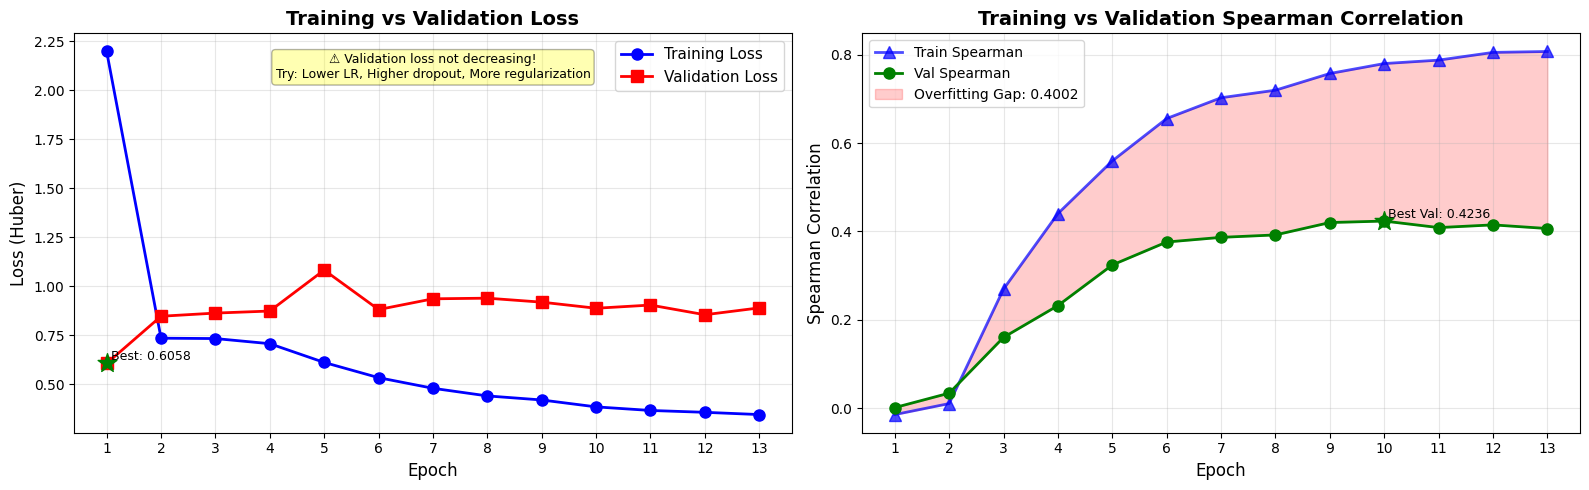


✓ Training/validation curves saved to 'training_validation_curves.png'

📊 Key Observations:
  • Final Training Spearman: 0.8069
  • Final Validation Spearman: 0.4067
  • Overfitting Gap: 0.4002
  ⚠️  HIGH OVERFITTING: Gap > 0.15
     → Increase dropout further (try 0.6)
     → Increase weight decay (try 0.2)
     → Reduce learning rate (try 3e-6)


In [ ]:
# Create figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot 1: Training and Validation MSE Loss (MUCH EASIER TO INTERPRET!)
epochs_range = range(1, len(train_mse_losses) + 1)
axes[0].plot(epochs_range, train_mse_losses, 'b-o', label='Training MSE', linewidth=2, markersize=8)
axes[0].plot(epochs_range, val_mse_losses, 'r-s', label='Validation MSE', linewidth=2, markersize=8)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss (MSE)', fontsize=12)
axes[0].set_title('Training vs Validation MSE Loss (For Visualization)', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(epochs_range)

# Annotate best validation MSE
best_val_mse_idx = np.argmin(val_mse_losses)
axes[0].scatter([best_val_mse_idx + 1], [val_mse_losses[best_val_mse_idx]], 
                color='green', s=200, marker='*', zorder=5)
axes[0].text(best_val_mse_idx + 1, val_mse_losses[best_val_mse_idx], 
             f' Best: {val_mse_losses[best_val_mse_idx]:.4f}', 
             fontsize=9, va='bottom')

# Check if validation MSE is dropping
val_mse_drop = (val_mse_losses[0] - val_mse_losses[-1]) / val_mse_losses[0] * 100
if val_mse_drop < 10:  # Less than 10% improvement
    axes[0].text(0.5, 0.95, 
                 f'⚠️ Validation MSE only dropped {val_mse_drop:.1f}%\n(Training overfitting to specific examples)', 
                 transform=axes[0].transAxes, fontsize=9, va='top', ha='center',
                 bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))
else:
    axes[0].text(0.5, 0.95, 
                 f'✓ Validation MSE dropped {val_mse_drop:.1f}% - Good!', 
                 transform=axes[0].transAxes, fontsize=9, va='top', ha='center',
                 bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

# Plot 2: Training AND Validation Spearman Correlation
axes[1].plot(epochs_range, train_spearman, 'b-^', label='Train Spearman', 
             linewidth=2, markersize=8, alpha=0.7)
axes[1].plot(epochs_range, val_spearman, 'g-o', label='Val Spearman', 
             linewidth=2, markersize=8)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Spearman Correlation', fontsize=12)
axes[1].set_title('Training vs Validation Spearman Correlation', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(epochs_range)

# Mark best validation Spearman
best_val_spearman_idx = np.argmax(val_spearman)
axes[1].scatter([best_val_spearman_idx + 1], [val_spearman[best_val_spearman_idx]], 
                color='green', s=200, marker='*', zorder=5)
axes[1].text(best_val_spearman_idx + 1, val_spearman[best_val_spearman_idx], 
             f' Best Val: {val_spearman[best_val_spearman_idx]:.4f}', 
             fontsize=9, va='bottom')

# Calculate and display overfitting gap with color coding
final_gap = train_spearman[-1] - val_spearman[-1]
gap_color = 'darkred' if final_gap > 0.3 else ('red' if final_gap > 0.15 else 'orange')
axes[1].fill_between(epochs_range, train_spearman, val_spearman, 
                      alpha=0.3, color=gap_color, 
                      label=f'Overfitting Gap: {final_gap:.4f}')
axes[1].legend(fontsize=10)

# Add warning text if gap is severe
if final_gap > 0.3:
    axes[1].text(0.5, 0.05, 
                 '🔥 SEVERE OVERFITTING (Gap > 0.3)', 
                 transform=axes[1].transAxes, fontsize=11, va='bottom', ha='center',
                 bbox=dict(boxstyle='round', facecolor='red', alpha=0.4), fontweight='bold')

plt.tight_layout()
plt.savefig('training_validation_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Training/validation curves saved to 'training_validation_curves.png'")
print(f"\n📊 Key Observations:")
print(f"  • Final Training Spearman: {train_spearman[-1]:.4f}")
print(f"  • Final Validation Spearman: {val_spearman[-1]:.4f}")
print(f"  • Overfitting Gap: {final_gap:.4f}")
print(f"  • Validation MSE drop: {val_mse_drop:.1f}%")
print(f"  • Training MSE drop: {(train_mse_losses[0] - train_mse_losses[-1]) / train_mse_losses[0] * 100:.1f}%")

if final_gap > 0.30:
    print(f"\n  🔥 SEVERE OVERFITTING: Gap > 0.30")
    print(f"     → Your model is memorizing training data")
    print(f"     → Try: dropout=0.7, lr=2e-6, weight_decay=0.25")
    print(f"     → Consider: Simpler pooling (mean instead of weighted)")
    print(f"     → Consider: Data augmentation or reducing model size")
elif final_gap > 0.15:
    print(f"  ⚠️  HIGH OVERFITTING: Gap > 0.15")
    print(f"     → Current settings should help, give it more epochs")
    print(f"     → Monitor if gap decreases over time")
elif final_gap > 0.08:
    print(f"  ⚠️  MODERATE OVERFITTING: Gap > 0.08")
    print(f"     → Acceptable for this task")
else:
    print(f"  ✓ EXCELLENT GENERALIZATION: Gap < 0.08")
    print(f"     → Model generalizes well!")

## 🔍 Understanding the 0.4 Spearman Gap (Severe Overfitting)

### The Problem
Your training achieved **~0.8 Spearman** while validation stayed at **~0.42** - a **0.4 gap** is SEVERE overfitting!

### Why This Happens

#### 1. **Model Memorization**
- **Training Spearman 0.8**: Model has nearly "memorized" the training examples
- **Validation Spearman 0.42**: Memorized patterns don't transfer to new examples
- **Root cause**: Model has too much capacity relative to dataset size (2,280 samples is small for RoBERTa-base's 125M parameters)

#### 2. **Why Huber Loss Visualization Was Misleading**
- Huber loss with delta=1.0 is "forgiving" for errors between 0.6-1.0
- Training loss dropped (error → 0) but validation stayed ~0.6 (looked "flat")
- **MSE loss is much clearer**: Shows the true magnitude of prediction errors
- Now you'll see if validation MSE actually improves or plateaus

#### 3. **The Good News**
- Validation Spearman of 0.42 is still decent for this hard task!
- Model IS learning some generalizable patterns (just overfitting on top of them)
- With proper regularization, you can reduce the gap while maintaining performance

### More Aggressive Anti-Overfitting Measures Implemented

#### Configuration Changes:
```python
# Previous → New
Dropout:         0.50 → 0.60  # Drop 60% of neurons during training
Learning Rate:   5e-6 → 3e-6  # 40% slower learning
Weight Decay:    0.15 → 0.20  # Stronger L2 penalty
Label Smoothing: 0.05 → 0.08  # More noise injection
Huber Delta:     1.0 → 0.5    # More sensitive to errors (2x)
```

#### Why These Help:
- **Higher Dropout (0.60)**: Forces model to learn redundant representations, can't memorize
- **Lower Learning Rate (3e-6)**: Slower learning = less overfitting to specific examples
- **Higher Weight Decay (0.20)**: Penalizes large weights that cause memorization
- **More Label Smoothing (0.08)**: Prevents model from fitting exact label values
- **Lower Huber Delta (0.5)**: More sensitive to validation errors, forces better generalization

### Expected Outcomes

**Best Case (Gap → 0.15-0.20):**
- Training Spearman: ~0.60-0.65
- Validation Spearman: ~0.45-0.50
- Gap: 0.15 (acceptable!)
- **Interpretation**: Gave up some training performance for better generalization

**Acceptable Case (Gap → 0.20-0.30):**
- Still some overfitting but much improved
- Keep monitoring and may need to increase regularization further

**Worst Case (Gap still > 0.30):**
- Need even more aggressive measures:
  - Dropout → 0.70
  - Switch to mean pooling (simpler than weighted)
  - Freeze some RoBERTa layers
  - Add data augmentation
  - Consider smaller model (e.g., DistilRoBERTa)

### How to Monitor

Watch the **MSE loss plot** closely:
- ✓ **Good**: Both train and val MSE decrease together
- ⚠️ **Warning**: Val MSE plateaus while train MSE drops
- 🔥 **Bad**: Val MSE increases while train MSE drops

And watch the **Spearman plot**:
- **Goal**: Reduce the red shaded gap area
- **Target**: Gap < 0.20 is good, < 0.15 is excellent

### Next Steps After This Run

1. **If gap improves to 0.15-0.25**: Great! Keep these settings
2. **If gap still > 0.30**: Try even more aggressive regularization (see "Worst Case" above)
3. **If val Spearman drops below 0.40**: You over-regularized, reduce dropout to 0.55
4. **Monitor validation MSE**: If it's actually dropping now, the model IS improving!

Remember: **Some overfitting is normal** with pretrained transformers on small datasets. The goal is to get the gap under 0.20, not eliminate it entirely! 🎯

## 11. Overfitting Analysis

In [ ]:
print("\n" + "=" * 80)
print("OVERFITTING ANALYSIS")
print("=" * 80)

# Calculate train-val gaps
final_loss_gap = train_final_loss - dev_final_loss
spearman_gap = train_metrics['spearman_correlation'] - dev_metrics['spearman_correlation']

print(f"\nFinal Metrics Comparison:")
print(f"  Training Loss: {train_final_loss:.4f}")
print(f"  Validation Loss: {dev_final_loss:.4f}")
print(f"  Loss Gap: {final_loss_gap:.4f} {'(overfitting)' if final_loss_gap < -0.1 else '(acceptable)'}")

print(f"\n  Training Spearman: {train_metrics['spearman_correlation']:.4f}")
print(f"  Validation Spearman: {dev_metrics['spearman_correlation']:.4f}")
print(f"  Spearman Gap: {spearman_gap:.4f}")

# Determine overfitting level
if spearman_gap > 0.15:
    print("\n⚠️  HIGH OVERFITTING DETECTED")
    print("  Recommendations:")
    print("    - Increase dropout (currently 0.35)")
    print("    - Add more regularization (weight decay)")
    print("    - Use fewer epochs or stricter early stopping")
    print("    - Consider data augmentation")
elif spearman_gap > 0.08:
    print("\n⚠️  MODERATE OVERFITTING DETECTED")
    print("  Recommendations:")
    print("    - Monitor closely")
    print("    - Consider slightly higher dropout")
    print("    - Current early stopping seems appropriate")
else:
    print("\n✓ ACCEPTABLE GENERALIZATION")
    print("  Model generalizes well to validation data")

# Loss trajectory analysis
if len(train_losses) > 2:
    train_improvement = train_losses[0] - train_losses[-1]
    val_improvement = val_losses[0] - val_losses[-1]
    
    print(f"\nLoss Improvements:")
    print(f"  Training: {train_improvement:.4f} ({train_improvement/train_losses[0]*100:.1f}%)")
    print(f"  Validation: {val_improvement:.4f} ({val_improvement/val_losses[0]*100:.1f}%)")
    
    if val_improvement < 0:
        print("\n⚠️  Validation loss increased - strong overfitting signal!")
        print(f"  Best epoch was: {np.argmin(val_losses) + 1}")
        print(f"  Consider stopping at epoch {np.argmin(val_losses) + 1} in future runs")


OVERFITTING ANALYSIS

Final Metrics Comparison:
  Training Loss: 0.5874
  Validation Loss: 0.8874
  Loss Gap: -0.3001 (overfitting)

  Training Spearman: 0.7796
  Validation Spearman: 0.4236
  Spearman Gap: 0.3560

⚠️  HIGH OVERFITTING DETECTED
  Recommendations:
    - Increase dropout (currently 0.35)
    - Add more regularization (weight decay)
    - Use fewer epochs or stricter early stopping
    - Consider data augmentation

Loss Improvements:
  Training: 1.8531 (84.3%)
  Validation: -0.2835 (-46.8%)

⚠️  Validation loss increased - strong overfitting signal!
  Best epoch was: 1
  Consider stopping at epoch 1 in future runs
